In [1]:
%matplotlib inline

In [2]:
import os
import sys

project_dir = os.path.split(os.getcwd())[0]

if project_dir not in sys.path:
   sys.path.append(project_dir)

from lyricanalysis import corpus

# Load up all of the songs for given artist

In [3]:
artist = 'Eminem'
songs = corpus.songs_for_artist(artist)

# Clean the lyrics

In [4]:
import re

tagged = re.compile('\[.*\]')
produced = re.compile('[p|P]roduced.*')

def clean_lyrics(lyrics):
    new_lyrics = tagged.sub('', lyrics)
    new_lyrics = produced.sub('', new_lyrics)
    
    return new_lyrics

for song in songs:
    song['lyrics'] = clean_lyrics(song['lyrics'])

# Word tokenize, remove stop words and stem

In [5]:
import string
import unicodedata
import sys

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.stem import PorterStemmer

import pandas as pd
import seaborn as sns

punc_tbl = dict.fromkeys(i for i in range(sys.maxunicode)
                      if unicodedata.category(chr(i)).startswith('P'))

def stem_words(words):
    stemmer = PorterStemmer()
    return [stemmer.stem(w) for w in words]

def remove_punctuation(text):
    return text.translate(punc_tbl)

def remove_stop_words(words):
    """Remove stop words from a list of words."""
    wl = []    
    stop_words = corpus.stop_words()
    for word in words:
        word = word.lower()
        if word not in stop_words:
            wl.append(word)
    
    return wl

normalized_word_frequencies = {}

for song in songs:
    song['word_tokens'] = stem_words(remove_stop_words(word_tokenize(remove_punctuation(song['lyrics']))))
    song['word_count'] = len(song['word_tokens'])
    dist = FreqDist(song['word_tokens'])

    for w in dist:
        if not w in normalized_word_frequencies:
            normalized_word_frequencies[w] = 0

        normalized_word_frequencies[w] = normalized_word_frequencies[w] + dist.freq(w)
        
for w, v in normalized_word_frequencies.items():
    normalized_word_frequencies[w] = v / len(songs)

/software/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


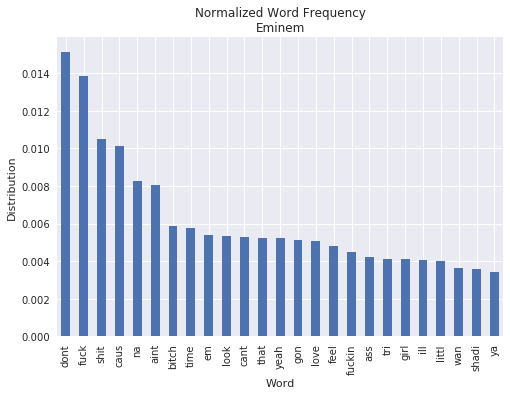

In [6]:
df = pd.DataFrame.from_dict(normalized_word_frequencies, orient='index')
word_freq = df.nlargest(25, 0).plot(kind='bar', title='Normalized Word Frequency\n%s' % (artist), legend=False)
word_freq.set_xlabel("Word")
word_freq.set_ylabel("Distribution")

# Stemmed and normalized swear word frequency

In [7]:
swear_words = set(stem_words(corpus.swear_words()))

normalized_word_frequencies = {}

for song in songs:
    song['word_tokens'] = stem_words(remove_stop_words(word_tokenize(remove_punctuation(song['lyrics']))))
    dist = FreqDist(song['word_tokens'])

    for sw in swear_words:
        if not sw in normalized_word_frequencies:
            normalized_word_frequencies[sw] = 0

        normalized_word_frequencies[sw] = normalized_word_frequencies[sw] + dist.freq(sw)
        
for w, v in normalized_word_frequencies.items():
    normalized_word_frequencies[w] = v / len(songs)

/software/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


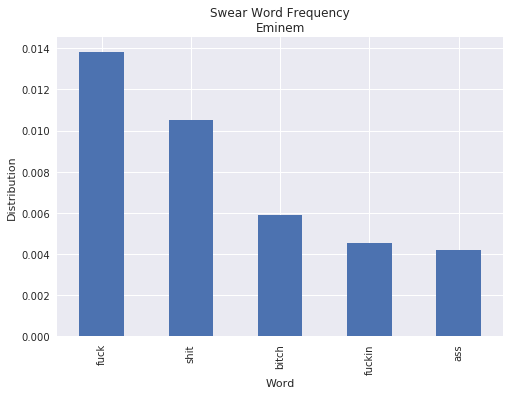

In [8]:
df = pd.DataFrame.from_dict(normalized_word_frequencies, orient='index')
word_freq = df.nlargest(5, 0).plot(kind='bar', title='Swear Word Frequency\n%s' % (artist), legend=False)
word_freq.set_xlabel("Word")
word_freq.set_ylabel("Distribution")

# Sentiment analysis with Vader

In [9]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize


def split_sentences(text):
    sentences = []
    for sentence in text.split('\n'):
        sentence = sentence.strip()
        
        if sentence:
            sentences.append(sentence)

    return sentences


def sentiment_for_song(text):
    sid = SentimentIntensityAnalyzer()

    # can't use sent_tokenize with lyrics... just split on newline
    sentences = split_sentences(text)
    total_ss = {
        'negative': 0,
        'positive': 0,
        'neutral': 0,
        'compound': 0
    }

    for sentence in sentences:
        ss = sid.polarity_scores(sentence)
        total_ss['negative'] = total_ss['negative'] + ss['neg']
        total_ss['positive'] = total_ss['positive'] + ss['pos']
        total_ss['neutral'] = total_ss['neutral'] + ss['neu']
        total_ss['compound'] = total_ss['compound'] + ss['compound']
        
    for key in total_ss:
        if len(sentences) > 0:
            total_ss[key] = total_ss[key] / len(sentences)
        
    return total_ss

all_sentiments = {}
for song in songs:
    sentiments = sentiment_for_song(song['lyrics'])

    # add sentiment to song data
    song['positive_sentiment'] = sentiments['positive']
    song['negative_sentiment'] = sentiments['negative']
    song['neutral_sentiment'] = sentiments['neutral']
    
    for key in sentiments:
        if key not in all_sentiments:
            all_sentiments[key] = 0
            
        all_sentiments[key] = all_sentiments[key] + sentiments[key]

# normalize for number of songs

for key in all_sentiments:
    all_sentiments[key] = all_sentiments[key] / len(songs)

print(all_sentiments)

/software/miniconda3/lib/python3.5/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


{'neutral': 0.7932126125538894, 'negative': 0.11869140141214184, 'compound': -0.06662312754832482, 'positive': 0.08169777852618663}


/software/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


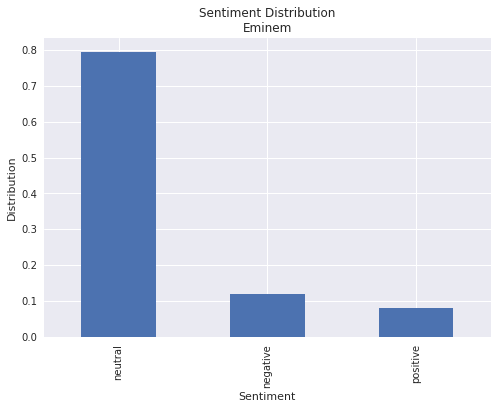

In [10]:
all_sentiments.pop('compound', 0)
df = pd.DataFrame.from_dict(all_sentiments, orient='index')
sent_plot = df.nlargest(10, 0).plot(kind='bar', title='Sentiment Distribution\n%s' % (artist), legend=False)
sent_plot.set_xlabel("Sentiment")
sent_plot.set_ylabel("Distribution")

# How repetitive?

Check how repetitive a song is by looking at the number of occurences each phrase or sentence has. A lot of songs are repetitive due to the nature of a chorus etc.. however some might be super repetitve.

/software/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


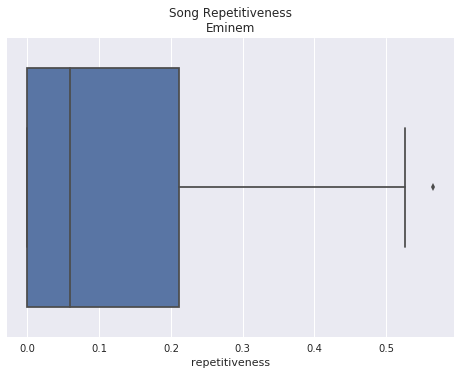

In [11]:
def song_repetiveness(lyrics, rate=2):
    # split song on sentence and find unique sentences
    sentences = split_sentences(lyrics)
    unique_sentences = set(sentences)
    
    total_sentences = len(sentences)
    total_unique_sentences = len(unique_sentences)
    
    # collect frequency of unique sentences and calculate reptetiveness
    repetitive_rate = 0
    frequency = 0
    for usentence in unique_sentences:
        for sentence in sentences:
            if usentence == sentence:
                frequency = frequency + 1

        # only calc. reptetiveness rate if frequency rate cutoff is met
        if frequency >= rate:
            repetitive_rate = repetitive_rate + (frequency / total_sentences)
            
        frequency = 0
        
    return repetitive_rate

for song in songs:
    song['repetitiveness'] = song_repetiveness(song['lyrics'], rate=2)
    
songs_df = pd.DataFrame.from_dict(songs)
# plot = songs_df.sort_values('repetitiveness').plot(y='repetitiveness', kind='box', title='Song Repetitiveness\n%s' % (songs[0]['artist']), stacked=True)
sns.boxplot(songs_df.repetitiveness)

sns.plt.title('Song Repetitiveness\n%s' % (songs[0]['artist']))

In [12]:
songs_df.sort_values('repetitiveness').head()

,album,artist,lyrics,lyrics_file,lyrics_file_path,lyrics_url,negative_sentiment,neutral_sentiment,positive_sentiment,repetitiveness,title,word_count,word_tokens
279,,Eminem,\n\n\nI know thereâs something in the wake o...,eminem-listen-to-your-heart.txt,/media/sf_D_DRIVE/jupyter/tyler/single_artist_...,http://www.azlyrics.com/lyrics/eminem/listento...,0.101436,0.836400,0.062164,0.0,Listen To Your Heart,215,"[thereâ, wake, smile, notion, look, eye, yea..."
298,,Eminem,"\n\nPsst... hey, listen! \nLalalalala! I love ...",eminem-stimulate.txt,/media/sf_D_DRIVE/jupyter/tyler/single_artist_...,http://www.azlyrics.com/lyrics/eminem/stimulat...,0.093475,0.788066,0.118475,0.0,Stimulate,205,"[psst, hey, listen, lalalalala, love, job, who..."
300,,Eminem,\n\nLet's take them back to the future (bars)\...,eminem-sway-in-the-morning-freestyle.txt,/media/sf_D_DRIVE/jupyter/tyler/single_artist_...,http://www.azlyrics.com/lyrics/eminem/swayinth...,0.129046,0.753771,0.117174,0.0,Sway In The Morning (Freestyle),480,"[futur, bar, bar, paul, rosenberg, frozen, tur..."
118,Curtain Call,Eminem,"\n\n\n\n\nMeet Eddie, twenty-three years old.\...",eminem-guilty-conscience.txt,/media/sf_D_DRIVE/jupyter/tyler/single_artist_...,http://www.azlyrics.com/lyrics/eminem/guiltyco...,0.154256,0.790269,0.055449,0.0,Guilty Conscience,289,"[meet, eddi, twentythre, fed, life, decid, rob..."
117,Curtain Call,Eminem,\n\nYeah\nI know sometimes things may not alwa...,eminem-mockingbird.txt,/media/sf_D_DRIVE/jupyter/tyler/single_artist_...,http://www.azlyrics.com/lyrics/eminem/mockingb...,0.082750,0.827804,0.089435,0.0,Mockingbird,301,"[yeah, sometim, sens, hey, daddi, tell, straig..."


# Correlations...

In [13]:
songs_df.describe()

,negative_sentiment,neutral_sentiment,positive_sentiment,repetitiveness,word_count
count,314.000000,314.000000,314.000000,314.000000,314.000000
mean,0.118691,0.793213,0.081698,0.115568,287.640127
std,0.045956,0.080922,0.029109,0.128343,144.973153
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.090651,0.769314,0.063336,0.000000,227.750000
50%,0.114783,0.802197,0.077259,0.059289,286.000000
75%,0.148983,0.827018,0.096768,0.211039,341.000000
max,0.308667,1.000000,0.171405,0.566038,1644.000000


# TFIDF SKLEARN

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,2), min_df = 0, stop_words = corpus.stop_words())

song_corpus = [song['lyrics'] for song in songs]

tfidf_matrix = tf.fit_transform(song_corpus)
feature_names = tf.get_feature_names()
dense = tfidf_matrix.todense()
song = dense[0].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(song)), song) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:20]:
   print('{0: <20} {1}'.format(phrase, score))

infinite             0.19902514365172327
tempted              0.17143295251562032
murderin instruments 0.1548611746318779
sentence murderin    0.1548611746318779
attempt infinite     0.14449867354223772
beat tempted         0.14449867354223772
heard hell           0.14449867354223772
hell sent            0.14449867354223772
infinite heard       0.14449867354223772
instruments          0.14449867354223772
instruments trying   0.14449867354223772
repent hear          0.14449867354223772
sent serving         0.14449867354223772
serving sentence     0.14449867354223772
tempted attempt      0.14449867354223772
trying repent        0.14449867354223772
murderin             0.13714636201249625
repent               0.13714636201249625
hear beat            0.1314434661346521
serving              0.12678386092285607


# Topic modelling...

In [15]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print()
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_topics = 5

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf_matrix)

# Run LDA
lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=20, learning_method='online', learning_offset=50.,random_state=0).fit(tfidf_matrix)

no_top_words = 5
display_topics(nmf, feature_names, no_top_words)
display_topics(lda, feature_names, no_top_words)

Topic 0:

don cause shit fuck re
Topic 1:

name name name huh hi yeah yeah
Topic 2:

paul incest incest rape shit guys album gotta
Topic 3:

woah alright drug woah woah steve
Topic 4:

daddy mommy mourn rejoice gone carry rejoice
Topic 0:

don cause shit fuck re
Topic 1:

boom sock boom boom boom chuck chuck
Topic 2:

constantly fu entertain fu ked ked
Topic 3:

paul woah phenomenal fuckin rub
Topic 4:

cinderella eminem eminem cinderella cinderella check check look mirror


# Find most repetitive, positive and negative song

In [16]:
songs_df[['album', 'title', 'repetitiveness']].nlargest(1, 'repetitiveness')

,album,title,repetitiveness
184,Straight From The Vault,Emulate,0.566038


In [17]:
songs_df[['album', 'title', 'positive_sentiment']].nlargest(1, 'positive_sentiment')

,album,title,positive_sentiment
191,Straight From The Vault,It's Been Real,0.171405


In [18]:
songs_df[['album', 'title', 'negative_sentiment']].nlargest(1, 'negative_sentiment')

,album,title,negative_sentiment
140,Relapse,Tonya (Skit),0.308667


# Find longest and shortest song

In [36]:
songs_df[['album', 'title', 'word_count']].nlargest(1, 'word_count')

,album,title,word_count
297,,SHADY CXVPHER,1644


In [39]:
songs_df[['album', 'title', 'word_count']].nsmallest(1, 'word_count')

,album,title,word_count
56,The Eminem Show,Curtains Up (Skit),0
101,Encore,Final Thought (Skit),0


/software/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


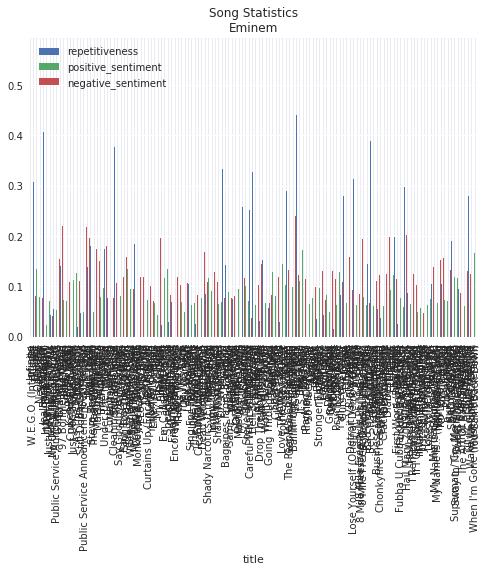

In [19]:
songs_df[['title', 'repetitiveness', 'positive_sentiment', 'negative_sentiment']].plot(kind='bar', x='title', title='Song Statistics\n%s' % (artist))

# Find most repetitive, positive and negative album

/software/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


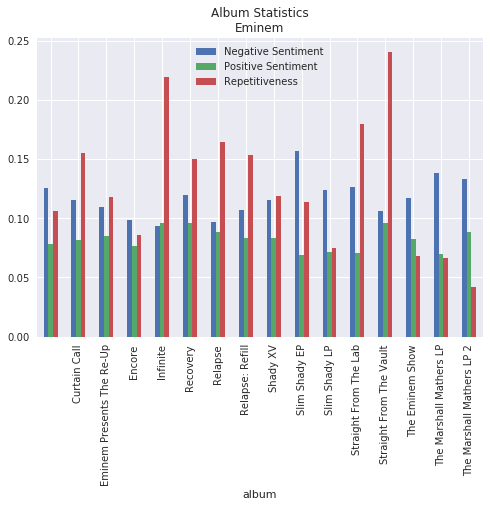

In [34]:
albums_groups = songs_df.groupby('album')['repetitiveness', 'negative_sentiment', 'positive_sentiment', 'word_count'].agg(['count', 'sum'])
albums_groups['repetitiveness_normalized'] = albums_groups['repetitiveness']['sum'] / albums_groups['repetitiveness']['count']
albums_groups['negative_sentiment_normalized'] = albums_groups['negative_sentiment']['sum'] / albums_groups['negative_sentiment']['count']
albums_groups['positive_sentiment_normalized'] = albums_groups['positive_sentiment']['sum'] / albums_groups['positive_sentiment']['count']
albums_groups['words_per_song'] = albums_groups['word_count']['sum'] / albums_groups['word_count']['count']
albums_groups.drop('repetitiveness', axis=1, inplace=True)
albums_groups.drop('positive_sentiment', axis=1, inplace=True)
albums_groups.drop('negative_sentiment', axis=1, inplace=True)
albums_groups.drop('word_count', axis=1, inplace=True)
album_stats = albums_groups.reset_index().stack()
album_stats = album_stats.rename(columns = {'repetitiveness_normalized':'Repetitiveness', 'negative_sentiment_normalized': 'Negative Sentiment', 'positive_sentiment_normalized': 'Positive Sentiment', 'words_per_song': 'Avg. Words Per Song'})
album_stats[['album', 'Negative Sentiment', 'Positive Sentiment', 'Repetitiveness']].plot(kind='bar', x='album', title='Album Statistics\n%s' % (artist))

# Find average words per song for each album

/software/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


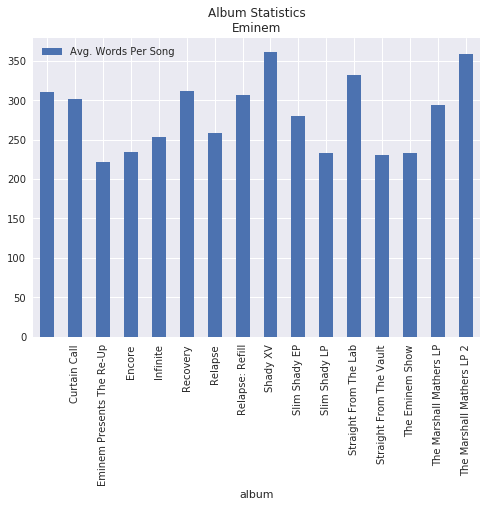

In [35]:
album_stats[['album', 'Avg. Words Per Song']].plot(kind='bar', x='album', title='Album Statistics\n%s' % (artist))

# Most repetitive album

In [21]:
album_stats.nlargest(1, 'Repetitiveness')

,,album,Negative Sentiment,Positive Sentiment,Repetitiveness
12,,Straight From The Vault,0.106396,0.096174,0.240381


# Most positive  album

In [22]:
album_stats.nlargest(1, 'Positive Sentiment')

,,album,Negative Sentiment,Positive Sentiment,Repetitiveness
5,,Recovery,0.11952,0.096297,0.150008


# Most negative  album

In [23]:
album_stats.nlargest(1, 'Negative Sentiment')

,,album,Negative Sentiment,Positive Sentiment,Repetitiveness
9,,Slim Shady EP,0.156506,0.068732,0.113445
